<a href="https://colab.research.google.com/github/HariharanV11/Stock-price-Prediction/blob/main/SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed



ADF Test on Original Series:
ADF Test Statistic: -0.8155898029288497
p-value: 0.8144997341990363
#Lags Used: 0
Number of Observations Used: 251
Series is non-stationary.

ADF Test on First Difference:
ADF Test Statistic: -14.937953227480625
p-value: 1.3358137634787129e-27
#Lags Used: 0
Number of Observations Used: 250
Series is stationary.

ADF Test on Seasonal Difference:
ADF Test Statistic: -2.6012540709076446
p-value: 0.09273835339729486
#Lags Used: 13
Number of Observations Used: 226
Series is non-stationary.


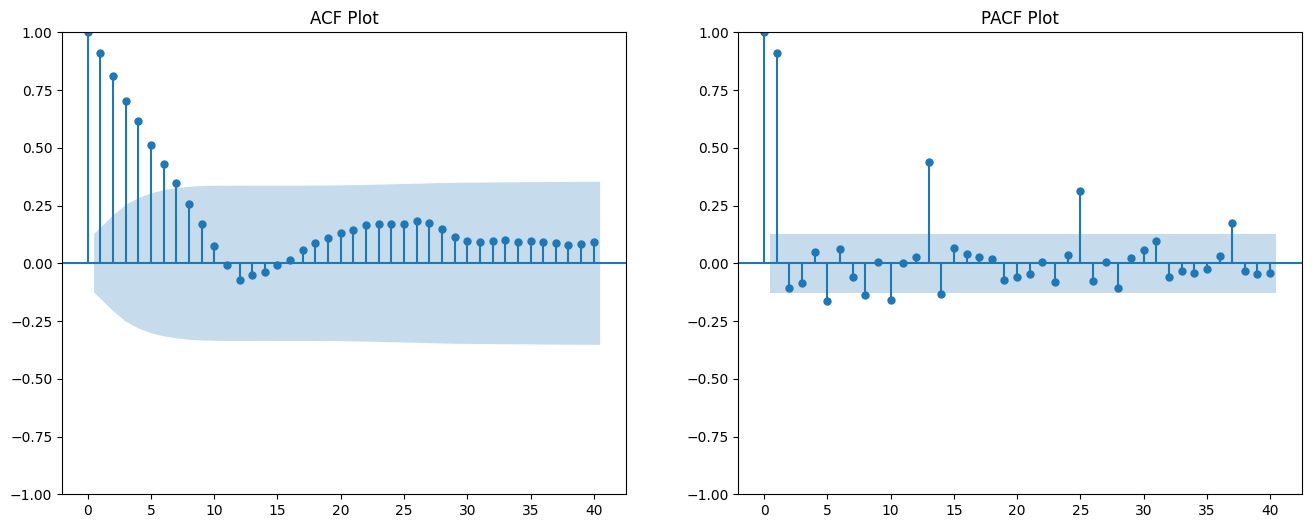

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                               AAPL   No. Observations:                  252
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -609.412
Date:                            Sat, 16 Nov 2024   AIC                           1228.823
Time:                                    14:51:31   BIC                           1246.205
Sample:                                         0   HQIC                          1235.828
                                            - 252                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0948      1.175     -0.081      0.936      -2.397       2.207
ma.L1          0.1591      1.158   

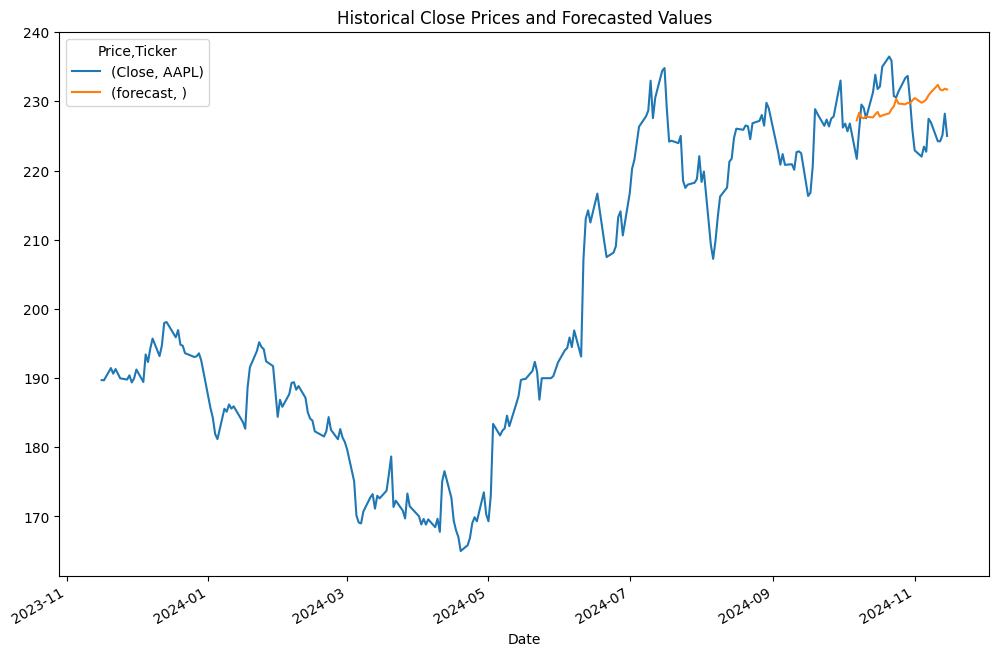

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Step 1: Fetch the data
ticker = 'AAPL'
df = yf.download(ticker, period="1y")
df = df[['Close']]

# Step 2: Preprocessing
df['Date'] = pd.to_datetime(df.index)
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)

# Step 3: Stationarity Check (ADF Test)
def adfuller_test(series):
    result = adfuller(series)
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(f"{label}: {value}")
    if result[1] <= 0.05:
        print("Series is stationary.")
    else:
        print("Series is non-stationary.")

# Original Series
print("\nADF Test on Original Series:")
adfuller_test(df['Close'])

# Step 4: Differencing for Stationarity
df['First Difference'] = df['Close'] - df['Close'].shift(1)
df['Seasonal Difference'] = df['Close'] - df['Close'].shift(12)

# Check stationarity after differencing
print("\nADF Test on First Difference:")
adfuller_test(df['First Difference'].dropna())
print("\nADF Test on Seasonal Difference:")
adfuller_test(df['Seasonal Difference'].dropna())

# Step 5: Plot ACF and PACF for Seasonal Differenced Series
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df['Seasonal Difference'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("ACF Plot")
plot_pacf(df['Seasonal Difference'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("PACF Plot")
plt.show()

# Step 6: SARIMAX Model
model = sm.tsa.statespace.SARIMAX(df['Close'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = model.fit()

# Model Summary
print(results.summary())

# Step 7: Forecasting within existing data range
df['forecast'] = results.predict(start=len(df) - 30, end=len(df) - 1, dynamic=True)

# Step 8: Calculate Accuracy
# Actual values for the last 30 days
actual = df['Close'][-30:]

# Predicted forecasted values for the last 30 days
predicted = df['forecast'][-30:]

# Calculate accuracy metrics
mae = mean_absolute_error(actual, predicted)  # Mean Absolute Error
mse = mean_squared_error(actual, predicted)  # Mean Squared Error
rmse = np.sqrt(mse)  # Root Mean Squared Error

# Print accuracy metrics
print("\nAccuracy Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Step 9: Plot Historical Close Prices and Forecasted Values
df[['Close', 'forecast']].plot(figsize=(12, 8), title="Historical Close Prices and Forecasted Values")
plt.show()
